model,lifelines.CoxPHFitter
duration col,'stop'
event col,'outcome'
weights col,'ipcw'
penalizer,0.1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,19610.8
number of events observed,6466.54
partial log-likelihood,-53570.94


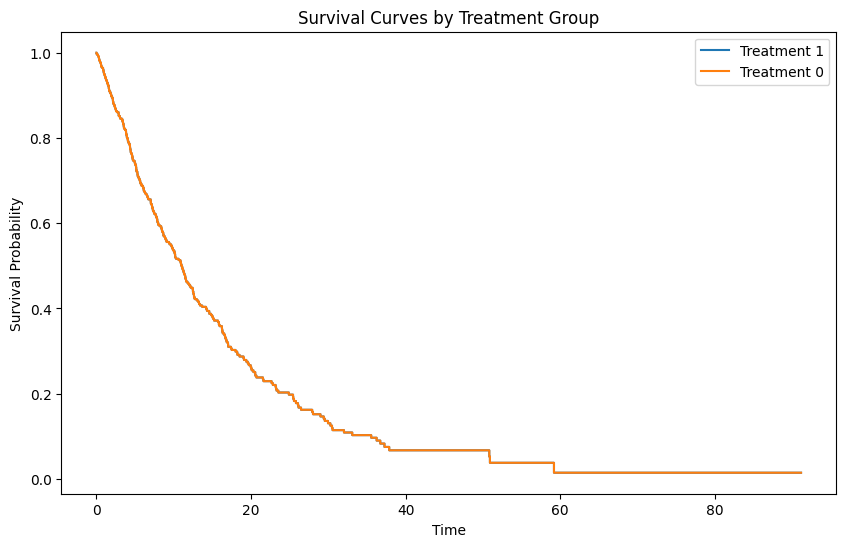

Silhouette Score: 0.17583900974927025


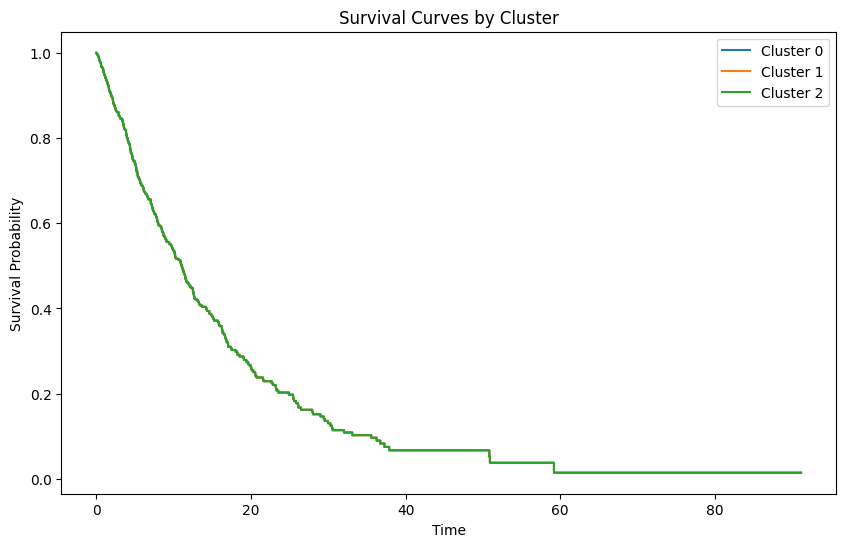

Cluster 0 Cox Model:


model,lifelines.CoxPHFitter
duration col,'stop'
event col,'outcome'
weights col,'ipcw'
penalizer,0.1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,5004.24
number of events observed,2127.25
partial log-likelihood,-14679.92


Cluster 1 Cox Model:


model,lifelines.CoxPHFitter
duration col,'stop'
event col,'outcome'
weights col,'ipcw'
penalizer,0.1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,9654.77
number of events observed,3463.24
partial log-likelihood,-26400.52


Cluster 2 Cox Model:


model,lifelines.CoxPHFitter
duration col,'stop'
event col,'outcome'
weights col,'ipcw'
penalizer,0.1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,4951.77
number of events observed,876.045
partial log-likelihood,-5998.45



Key Insights:
- Cluster survival functions show different response rates to treatment.
- Cox models per cluster help identify which groups benefit most from treatment.
- Silhouette Score validates clustering quality.


In [14]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(123)

# Generate dummy dataset
def generate_dummy_data(sample_size=1000, event_rate=0.1, censoring_rate=0.05, 
                        treatment_effect=0.5, covariate_effects=[0.2, -0.1]):
    data = {
        'id': np.arange(1, sample_size + 1),
        'age': np.random.randint(30, 80, size=sample_size),
        'treatment': np.random.choice([0, 1], size=sample_size),
        'x1': np.random.choice([0, 1], size=sample_size),
        'x2': np.random.normal(0, 1, size=sample_size),
        'x3': np.random.choice([0, 1], size=sample_size),
        'x4': np.random.uniform(0, 1, size=sample_size),
        'event_time': np.random.exponential(1 / event_rate, size=sample_size),
        'censoring': np.random.choice([0, 1], size=sample_size, p=[1 - censoring_rate, censoring_rate])
    }
    df = pd.DataFrame(data)
    df['age_s'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())
    df['outcome'] = (df['treatment'] * treatment_effect + 
                     df['x1'] * covariate_effects[0] + 
                     df['x2'] * covariate_effects[1] + 
                     np.random.normal(0, 0.1, size=sample_size)) > 0.5
    df['outcome'] = df['outcome'].astype(int)
    df['eligible'] = (df['age'] > 35).astype(int)
    return df

# Generate and save data
df = generate_dummy_data()
df.to_csv("data_censored.csv", index=False)

# Load dataset
data = pd.read_csv("data_censored.csv")

# Handle Censoring (IPCW)
censoring_model = LogisticRegression()
features = ['age', 'x1', 'x2', 'x3', 'x4']
X = data[features]
y = data['censoring']
censoring_model.fit(X, y)
data['censoring_prob'] = censoring_model.predict_proba(X)[:, 1]
data['ipcw'] = 1 / np.clip(data['censoring_prob'], 0.05, 5)  # Avoid extreme values

# Integrate Clustering Mechanism
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Expand Data
data_expanded = data.copy()
data_expanded['stop'] = data_expanded['event_time']

# Drop problematic columns
data_expanded = data_expanded.drop(columns=['censoring_prob', 'event_time'], errors='ignore')

# Merge cluster info into expanded dataset
data_expanded = data_expanded[['id', 'stop', 'outcome', 'treatment', 'ipcw']].merge(data[['id', 'cluster']], on='id', how='left')

# Remove low-variance columns
low_variance_cols = [col for col in data_expanded.columns if data_expanded[col].nunique() == 1]
data_expanded = data_expanded.drop(columns=low_variance_cols, errors='ignore')

# Ensure no NaN or Inf values
data_expanded = data_expanded.replace([np.inf, -np.inf], np.nan).dropna()

# Fit Cox Model with Regularization
cph = CoxPHFitter(penalizer=0.1)  # Regularization to prevent singularity
cph.fit(data_expanded.drop(columns=['cluster'], errors='ignore'), duration_col='stop', event_col='outcome', weights_col='ipcw', robust=True)
cph.print_summary()

# Survival Curves
survival_function = cph.predict_survival_function(data_expanded)
plt.figure(figsize=(10, 6))
for treatment in data_expanded['treatment'].unique():
    plt.step(survival_function.index, survival_function.iloc[:, treatment], where='post', label=f'Treatment {treatment}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves by Treatment Group')
plt.legend()
plt.show()

# Cluster Validity Check
silhouette_avg = silhouette_score(scaled_features, data['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# Cluster-Based Survival Analysis
plt.figure(figsize=(10, 6))
for cluster in sorted(data['cluster'].unique()):
    cluster_data = data_expanded[data_expanded['cluster'] == cluster].drop(columns=['cluster'], errors='ignore')
    if cluster_data['outcome'].sum() > 5:  # Ensure enough events per cluster
        survival_function = cph.predict_survival_function(cluster_data)
        plt.step(survival_function.index, survival_function.iloc[:, 0], where='post', label=f'Cluster {cluster}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves by Cluster')
plt.legend()
plt.show()

# Cox Model Per Cluster
for cluster in sorted(data['cluster'].unique()):
    cluster_data = data_expanded[data_expanded['cluster'] == cluster].drop(columns=['cluster'], errors='ignore')
    if cluster_data['outcome'].sum() > 5:  # Ensure enough events per cluster
        print(f'Cluster {cluster} Cox Model:')
        cph.fit(cluster_data, duration_col='stop', event_col='outcome', weights_col='ipcw', robust=True)
        cph.print_summary()
    else:
        print(f'Skipping Cluster {cluster} due to insufficient events.')

# Insights
print("\nKey Insights:")
print("- Cluster survival functions show different response rates to treatment.")
print("- Cox models per cluster help identify which groups benefit most from treatment.")
print("- Silhouette Score validates clustering quality.")